In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from multihist import Hist1d, Histdd
import datetime
import time 
import straxen
import strax
import cutax
straxen.print_versions()

,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.3/b...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.3/l...,None
2,straxen,1.7.1,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.3/l...,None
3,cutax,1.12.0,/dali/lgrandi/xenonnt/software/cutax/v1.12.0/c...,None


In [2]:
ddir = '/dali/lgrandi/dandrea/data'
events = pd.read_pickle(f'{ddir}/run047290_event_basics.pkl')
peaks = pd.read_pickle(f'{ddir}/run047290_peak_basics.pkl')
events_mv = np.load(f'{ddir}/run047290_events_mv.npy')

In [3]:
st = cutax.contexts.xenonnt_online(cut_list=[cutax.cut_lists.basic.BasicCuts,cutax.cut_lists.kr83m.Kr83mSelection])

In [4]:
ev0 = st.get_df('047289','event_basics')
peaks0 = st.get_df('047289','peak_basics')
ev_mv0 = st.get_array('047289','events_mv')

Loading event_basics: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

Loading events_mv: |          | 0.00 % [00:00<?]

In [5]:
records = pd.read_pickle(f'{ddir}/run047290_records.pkl')

In [6]:
def plotwf(data,nn,color='b'):
    dt = data['dt'][0]
    print('Total number of records',data['data'].shape[0])
    dts = np.arange(0,110*dt,dt)
    fig, axs = plt.subplots(nn,figsize=(12,8))
    for i in range(nn):
        chn = data['channel'][i]
        axs[i].plot(dts,data['data'][i],drawstyle='steps',color=color,label=f'chn {chn}')
        print(data['record_i'][i])
        axs[i].set_xlabel("time (ns)", ha='right', x=1)
        axs[i].set_ylabel(f"ADC", ha='right', y=1)
        axs[i].legend()

In [7]:
def find_overlap_on_records(records,ibreak=100):
    times = records['time']
    #areas = records['area']
    chns = records['channel']
    recs = records['record_i']
    dt = records['dt'][0]
    print(f'Total events n. {len(records)}')
    t_start = time.time()
    nsel = 0
    for i, t in enumerate(times[:-2]):
        diff = time.time() - t_start
        if (i % 100000) ==0: print(f'event n. {i}, time to process {diff:.2f} s')
        for j in range(1,500):
            if (chns[i] != chns[i+j]): continue
            tshift = times[i+j]-t
            if (tshift>1090): continue
            tempo = datetime.datetime.fromtimestamp(t/1e9)
            wfs1 = records['data'][i]
            wfs2 = records['data'][i+j]
            dts1 = np.arange(0,len(wfs1)*dt,dt)
            dts2 = np.arange(tshift,tshift+len(wfs2)*dt,dt)
            nsel += 1
            print(nsel,i, 'PMT',int(chns[i]),int(recs[i]),int(recs[i+j]),tshift)
            plt.figure(figsize=(8,4.5))
            plt.plot(dts1,wfs1,label=f'chn {chns[i]}, record {recs[i]}')
            plt.plot(dts2,wfs2,ls='--',label=f'chn {chns[i+j]}, record {recs[i+j]:.0f}, shift {tshift} ns')
            plt.ylabel('counts', ha='right', y=1)
            plt.xlabel('time (ns)', ha='right', x=1)
            plt.legend()
        if i > ibreak or nsel > 10: break

Total events n. 10865572
event n. 0, time to process 0.00 s
1 0 PMT 336 0 1 1024.0
2 3 PMT 169 0 1 1024.0
3 213 PMT 168 0 1 1024.0
4 215 PMT 184 0 1 1024.0
5 258 PMT 455 0 1 1024.0
6 334 PMT 282 0 1 1024.0
7 530 PMT 92 0 1 1024.0
8 536 PMT 123 0 1 1024.0
9 560 PMT 21 0 1 1024.0
10 562 PMT 1 0 1 1024.0
11 717 PMT 295 0 1 1024.0


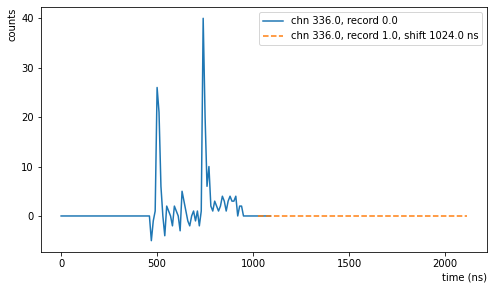

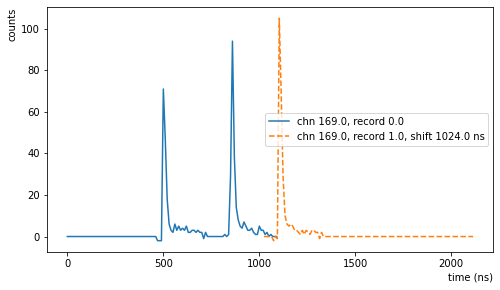

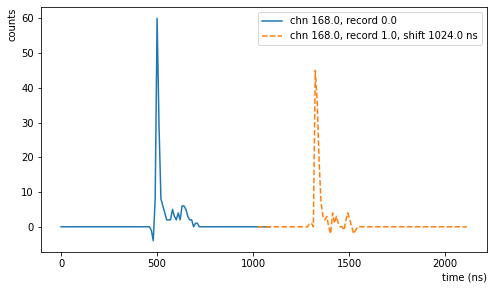

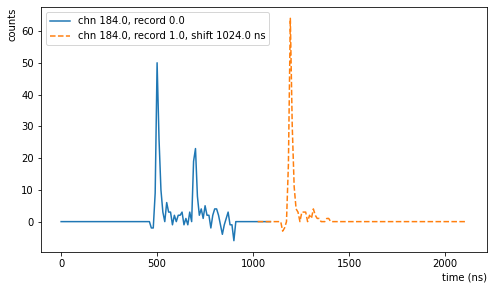

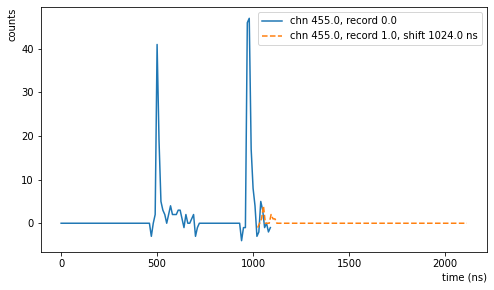

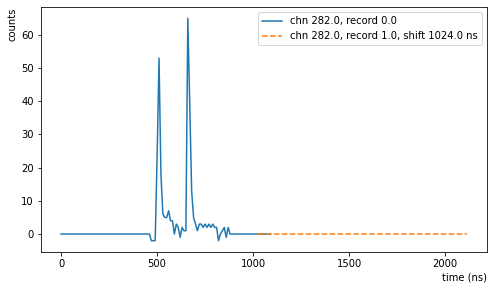

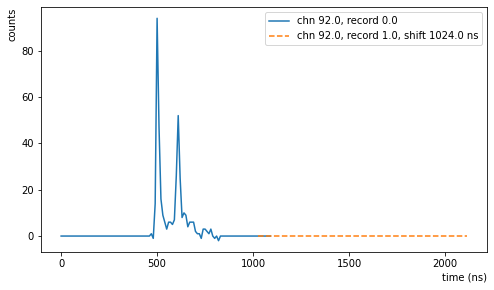

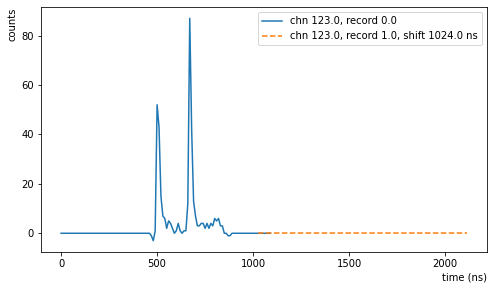

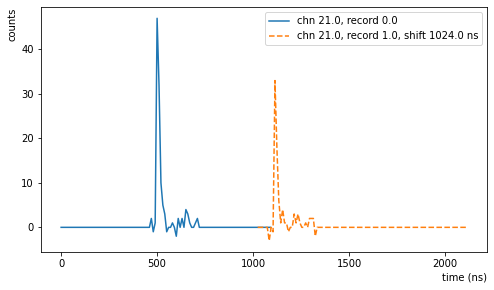

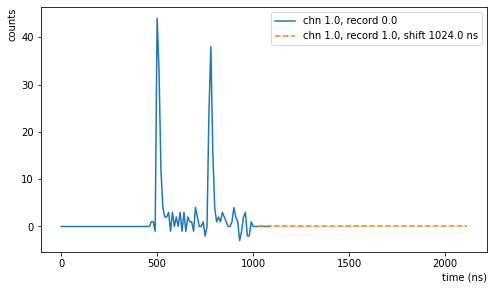

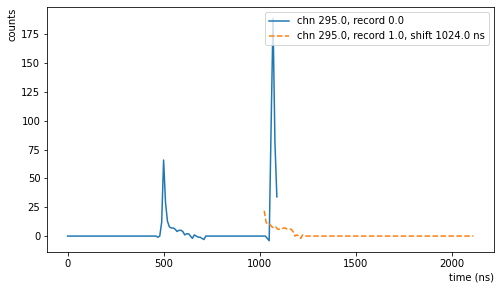

In [10]:
find_overlap_on_records(records,ibreak=10000)

In [9]:
def find_overlap_on_records_no_zero(records,ibreak=100):
    times = records['time']
    #areas = records['area']
    chns = records['channel']
    recs = records['record_i']
    dt = records['dt'][0]
    print(f'Total events n. {len(records)}')
    t_start = time.time()
    nsel = 0
    for i, t in enumerate(times[:-2]):
        diff = time.time() - t_start
        if (i % 100000) == 0: print(f'event n. {i}, time to process {diff:.2f} s')
        n = len(times[ ( times > t) & ( times < t + 1100 ) ] )
        for j in range(1,n+2):
            #print(j,t,times[i+j],times[i+j]-t)
            tshift = times[i+j]-t
            if (chns[i] != chns[i+j]) or (tshift>1090): continue
            #print(i, 'PMT',int(chns[i]),int(recs[i]),int(recs[i+j]),tshift)
            #tempo = datetime.datetime.fromtimestamp(t/1e9)
            wf1 = records['data'][i]
            wf2 = records['data'][i+j]
            wf1, wf2 = wf1[wf1!=0], wf2[wf2!=0]
            if wf1.size & wf2.size:
                dt1 = np.arange(0,len(wf1)*dt,dt)
                dt2 = np.arange(tshift,tshift+len(wf2)*dt,dt)
                if dt1[-1] >= dt2[0]:
                    nsel += 1
                    print(nsel,i,j, 'PMT',int(chns[i]),int(recs[i]),int(recs[i+j]),tshift)
                    plt.figure(figsize=(8,4.5))
                    plt.plot(dt1,wf1,label=f'chn {chns[i]}, record {recs[i]}, lenght {len(wf1)}')
                    plt.plot(dt2,wf2,ls='--',label=f'chn {chns[i+j]}, record {recs[i+j]}, lenght {len(wf2)}, shift {tshift} ns')
                    plt.ylabel('counts', ha='right', y=1)
                    plt.xlabel('time (ns)', ha='right', x=1)
                    plt.legend()
        if i > ibreak or nsel > 10: break

In [ ]:
find_overlap_on_records_no_zero(raw_records,ibreak=100)

# MUON VETO

In [11]:
#start = events['time'][0]
#print('Starting time',start)
#times = (events['time']-start)
#ends = (events['endtime']-start)
#chns = events['s1_n_channels']
start = records['time'][0]
tend = records['time'][records.last_valid_index()]
ev_mv = events_mv[(events_mv['time']>start)&(events_mv['time']<tend)]

In [13]:
def muon_veto_event_selection(events_mv, records):
    chns_mv = events_mv['n_contributing_pmt']
    times_mv = events_mv['time']
    end_mv = events_mv['endtime']
    times = records['time']
    print('Start time TPC',datetime.datetime.fromtimestamp(times[0]/1e9))
    print('Start time MV',datetime.datetime.fromtimestamp(times_mv[0]/1e9))
    nmv = 0
    print(len(times_mv))
    for i, tmv in enumerate(times_mv):
        print(i,times_mv[i],chns_mv[i],)
        sel = ( times > tmv - 300 ) & ( times < tmv + 1000 )
        tsel = set(np.array(times[sel]))
        if tsel:
            print(tsel)
            nmv += 1
            plt.figure(figsize=(8,4.5))
            for j, ts in enumerate(tsel):
                chn = records['channel'][i]
                print(i,j,chn,int(records['record_i'][i]),records['area'][i], ts-tmv)
                wfs = records['data'][i]
                dts = np.arange(ts-tmv,ts-tmv+len(wfs)*10,10)
                plt.plot(dts,wfs,label=f'chn {chn}, time shift {ts-tmv} ns')
            plt.ylabel('counts', ha='right', y=1)
            plt.xlabel('time (ns)', ha='right', x=1)
            plt.legend()
        if nmv > 10: break

Start time TPC 2022-08-29 20:18:17.000173
Start time MV 2022-08-29 20:18:17.045782
864
{1.6618223021892513e+18}
85 0 473.0 0 170.0 768.0
{1.6618223050322716e+18, 1.661822305032272e+18, 1.6618223050322721e+18, 1.6618223050322724e+18}
124 0 240.0 0 166.0 0.0
124 1 240.0 0 166.0 256.0
124 2 240.0 0 166.0 512.0
124 3 240.0 0 166.0 768.0
{1.6618223090262387e+18, 1.661822309026239e+18, 1.6618223090262392e+18}
184 0 160.0 0 44.0 0.0
184 1 160.0 0 44.0 256.0
184 2 160.0 0 44.0 512.0
{1.6618223106428285e+18}
204 0 36.0 0 146.0 0.0
{1.6618223158050255e+18}
258 0 455.0 0 228.0 512.0
{1.661822317579401e+18}
282 0 347.0 0 124.0 768.0
{1.661822320252465e+18}
338 0 460.0 0 63.0 256.0
{1.6618223306136136e+18}
467 0 332.0 0 114.0 -256.0
{1.6618223382836797e+18, 1.66182233828368e+18}
596 0 375.0 0 154.0 512.0
596 1 375.0 0 154.0 768.0
{1.661822339711633e+18, 1.6618223397116332e+18, 1.6618223397116334e+18, 1.6618223397116337e+18}
618 0 68.0 0 137.0 0.0
618 1 68.0 0 137.0 256.0
618 2 68.0 0 137.0 512.0
61

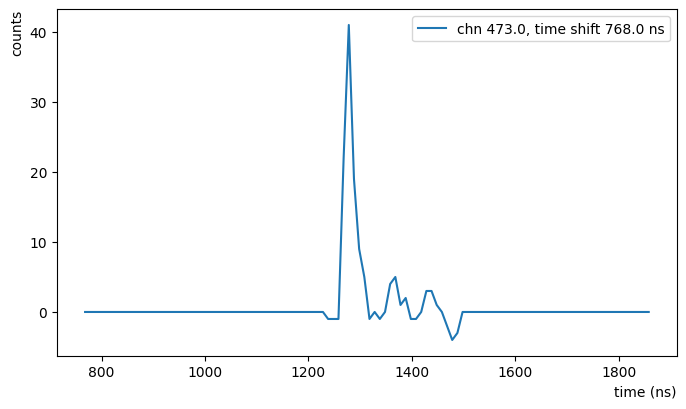

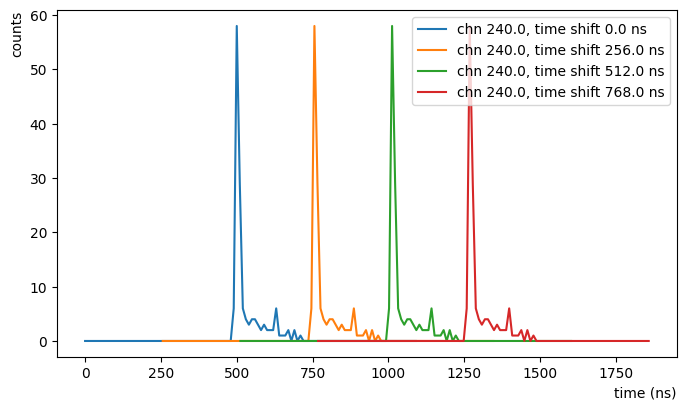

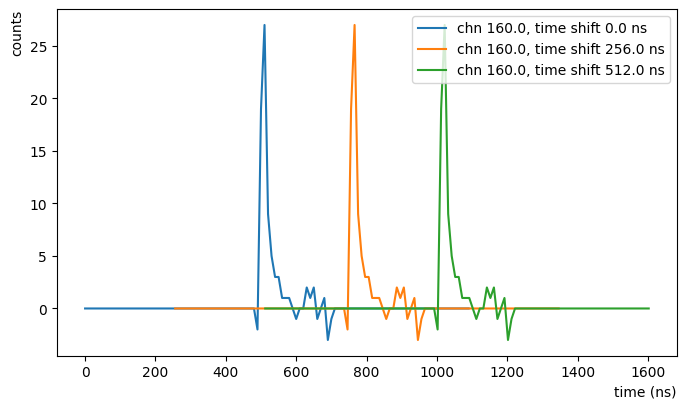

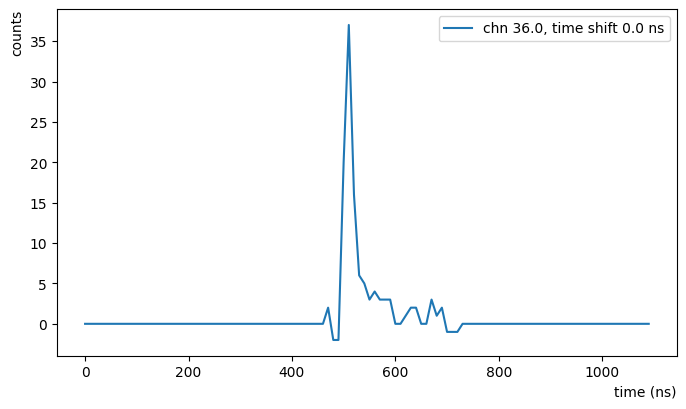

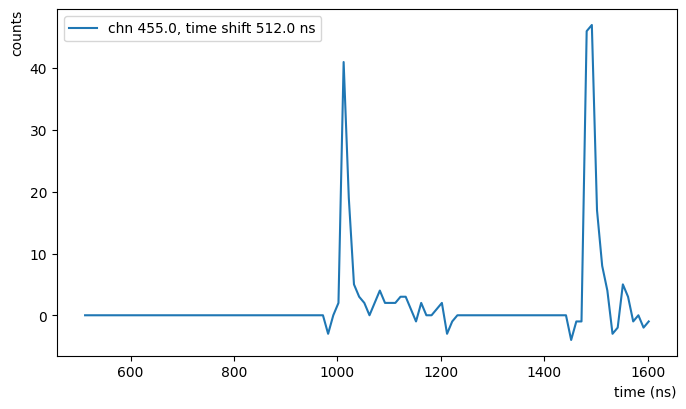

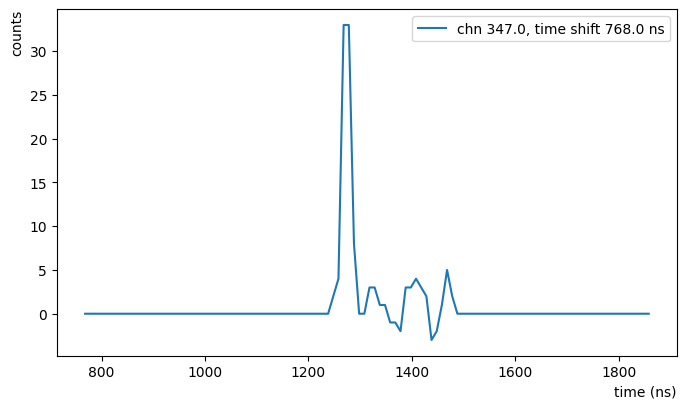

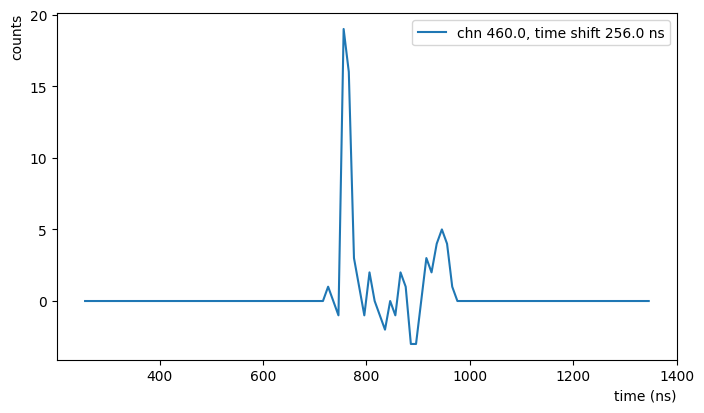

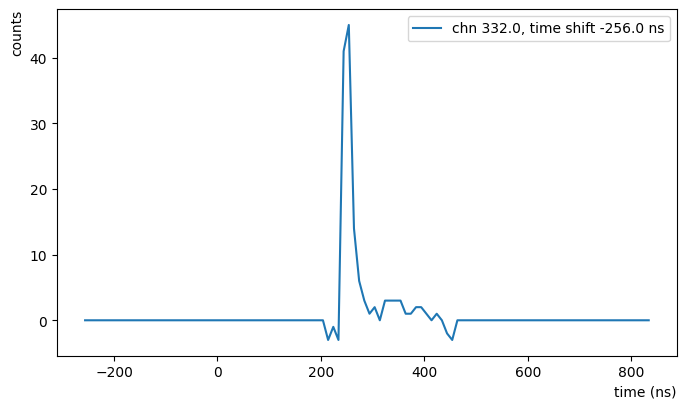

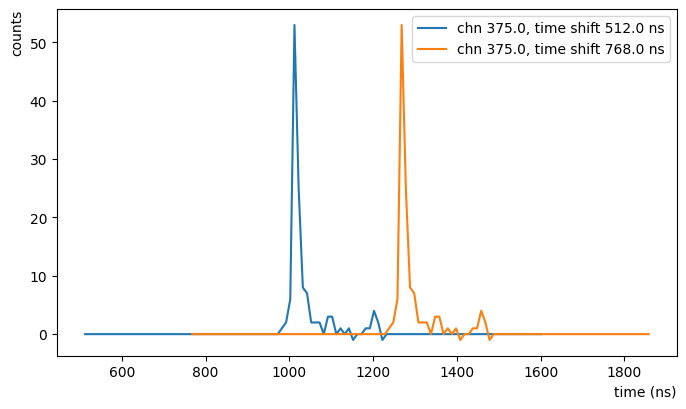

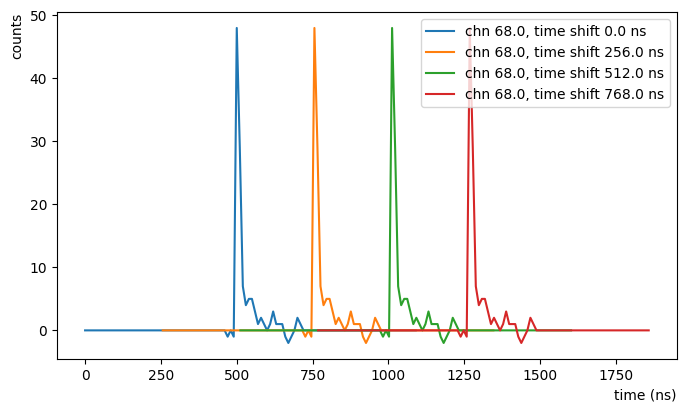

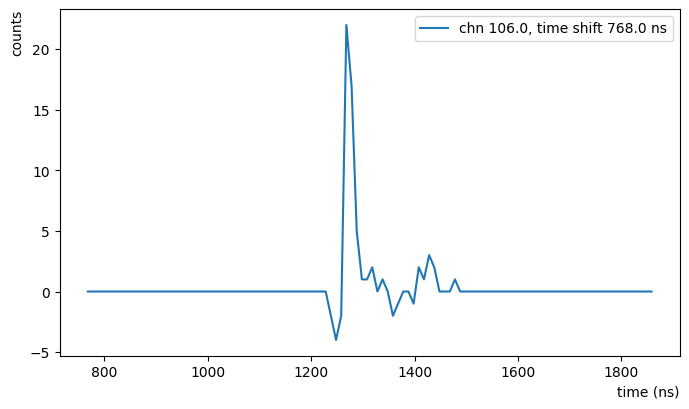

In [14]:
muon_veto_event_selection(ev_mv, records)

In [59]:
def plot_rate(events, low = 1, high = 6, low2 = 2, high2 = 4.5, low3 = 0.4, high3 = 0.9, binning=500):
    start_time = datetime.datetime.fromtimestamp(events['time'][0]/1e9)
    livetime = (events['time'][len(events)-1]-events['time'][0])/1e9
    #events = events[mask]
    ph_s1 = Histdd(events['s1_area'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_area'], events['s1_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    #kr_rate = len(events)/livetime
    all_rate = len(events)/livetime
    print(f'start {start_time}, total events {len(events)}, livetime {livetime:.2f} s, rate: {all_rate:.2f} Hz')
    kr_rates, all_rates, slot_times = [], [], []
    div = 5000
    for i in range(div):
        idx1, idx2 = int(i*(len(events)-1)/div), int((i+1)*(len(events)-1)/div)
        slot_time = (events['time'][idx2]-events['time'][idx1])/1e9
        trange = (events['time']>events['time'][idx1]) & (events['time']<events['time'][idx2])
        all_rates = np.append(all_rates,len(events[trange])/slot_time)
        timestamp = events['time'][idx1]/1e9
        #print(datetime.datetime.fromtimestamp(timestamp))
        #slot_times = np.append(slot_times,datetime.datetime.fromtimestamp(timestamp))
        slot_times = np.append(slot_times,timestamp)
    plt.figure(figsize=(8,4.5))
    #dates = matplotlib.dates.date2num(slot_times)# + datetime.timedelta(hours=7))
    #plt.plot_date(dates, kr_rates,'o',label='Kr-83m rate')
    plt.plot(slot_times-slot_times[0], all_rates,'-',label='total rate')
    #myFmt = matplotlib.dates.DateFormatter('%d%bH%H')
    #plt.gca().xaxis.set_major_formatter(myFmt)
    plt.xlabel("run time (s)", ha='right', x=1)
    plt.ylabel("rate (Hz)", ha='right', y=1)
    plt.legend()
    
    
    plt.figure(figsize=(8,4.5))
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.xscale('log')
    plt.yscale('log')
    #psu.rectangle(area_cut, width_cut, 'r')
        
    plt.figure(figsize=(8,4.5))
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.xscale('log')
    #psu.rectangle(area_cut, aft_cut, 'r')

start 2022-08-29 19:28:17.021663, total events 60444, livetime 10803.69 s, rate: 5.59 Hz


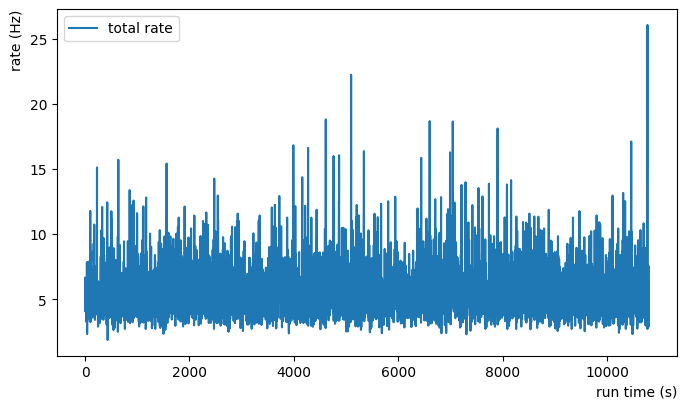

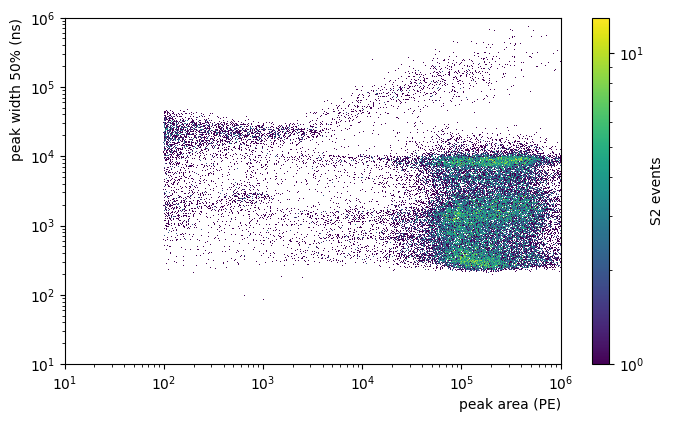

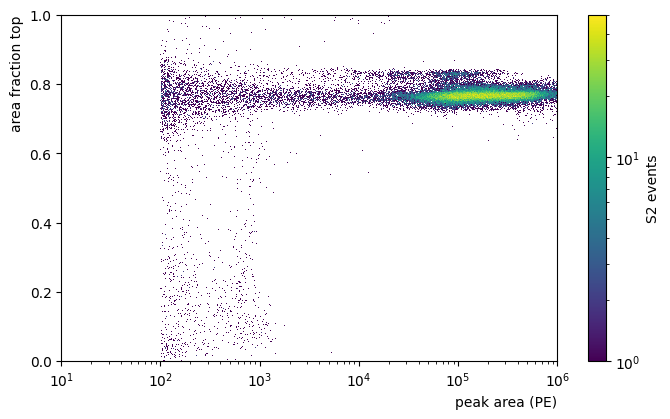

In [60]:
plot_rate(events)

Text(0, 1, 'n channels')

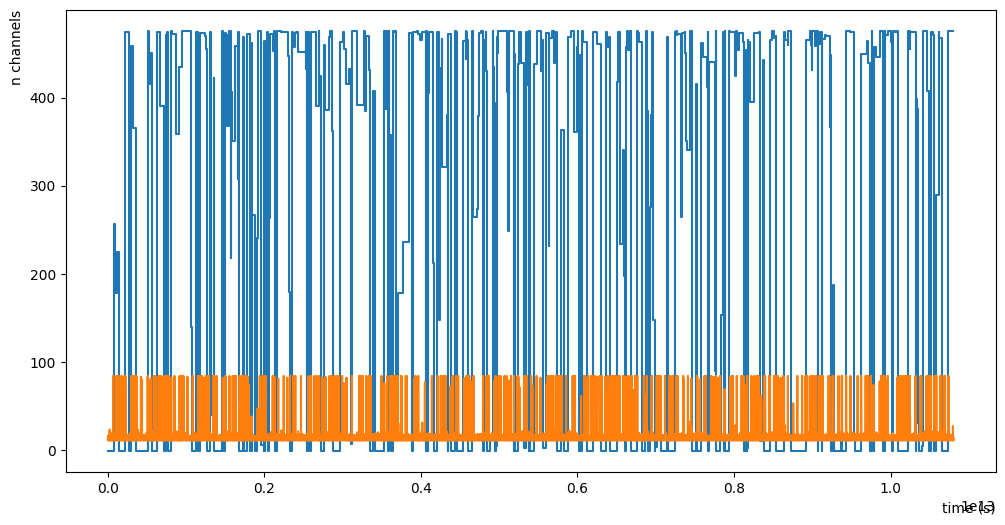

In [9]:
plt.figure(figsize=(12,6))
plt.plot(events[mv_,chns[mv_tag],ds='steps')
plt.plot(times_mv,chns_mv,ds='steps',label='MV channels')
plt.xlabel("time (s)", ha='right', x=1)
plt.ylabel("n channels", ha='right', y=1)
#plt.xscale('log')

In [5]:
def plot_area_width_aft(events, run_id = '047290', low = 0, high = 7, low2 = 0, high2 = 1, binning = 500):
    print('total events',len(events))
    ph_s1 = Histdd(events['s1_area'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_area'], events['s1_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'{run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'{run_id}')
    plt.xscale('log')

total events 60444


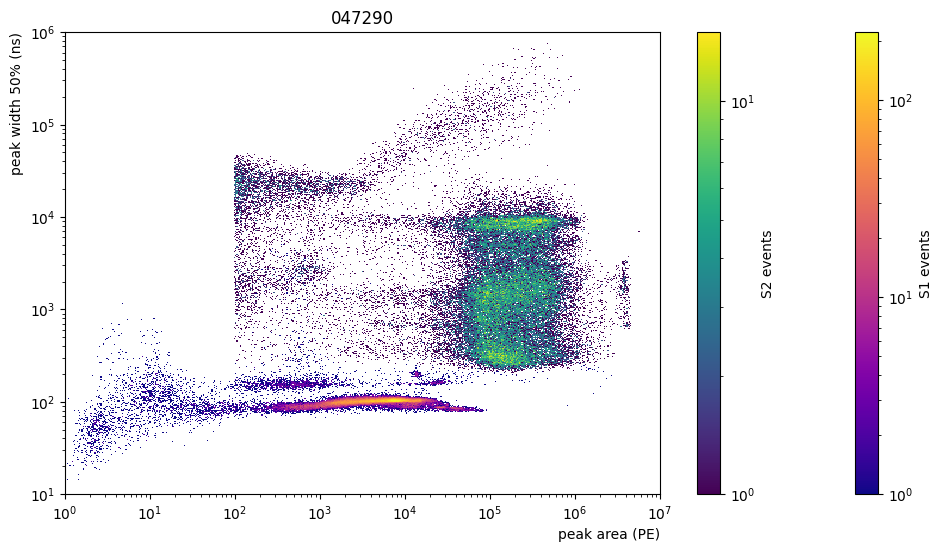

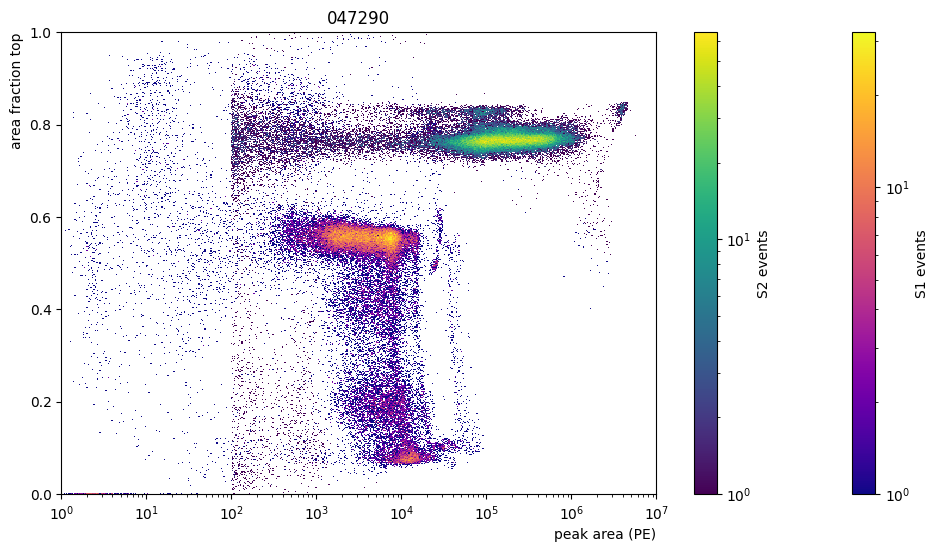

In [6]:
plot_area_width_aft(events)

In [ ]:
len(times[mv_tag])

473

In [62]:
def plot_peaks_area_width_aft(peaks,low=0,high=5,low_w=1,high_w=5,low_t=-2,high_t=0,binning=500):
    ph50 = Histdd(peaks['area'], peaks['range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low_w, high_w, binning)))
    plt.figure(figsize=(12,6))
    ph50.plot(log_scale=True, cblabel='events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.xscale('log')
    plt.yscale('log')
    phmax = Histdd(peaks['area'], peaks['area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.logspace(low_t, high_t, binning)))
    plt.figure(figsize=(12,6))
    phmax.plot(log_scale=True, cblabel='events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    #plt.ylabel("max PMT area (PE)", ha='right', y=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.xscale('log')
    
    phmax = Histdd(peaks['area'], peaks['max_pmt_area']/peaks['area'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, 200)))
    plt.figure(figsize=(12,6))
    phmax.plot(log_scale=True, cblabel='events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    #plt.ylabel("max PMT area (PE)", ha='right', y=1)
    plt.ylabel("max PMT area fraction", ha='right', y=1)
    plt.xscale('log')
    #plt.yscale('log')

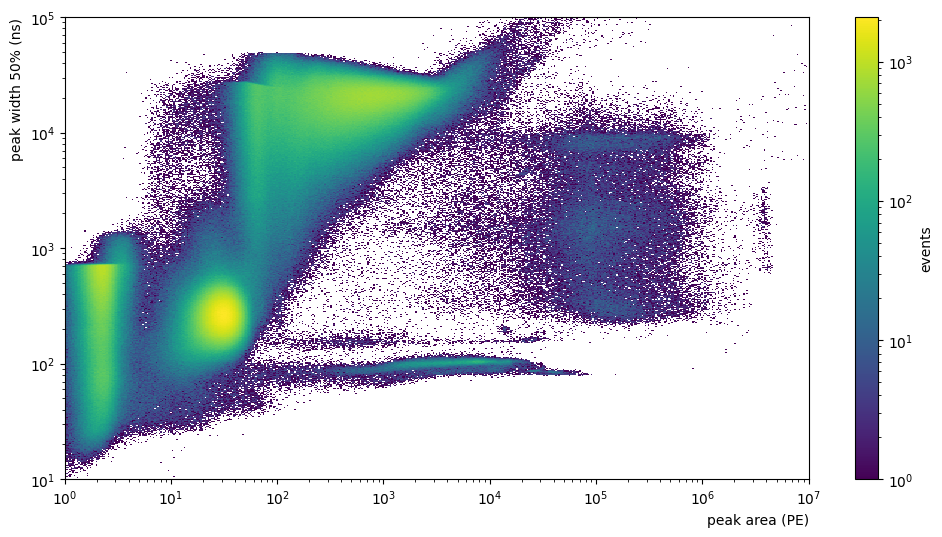

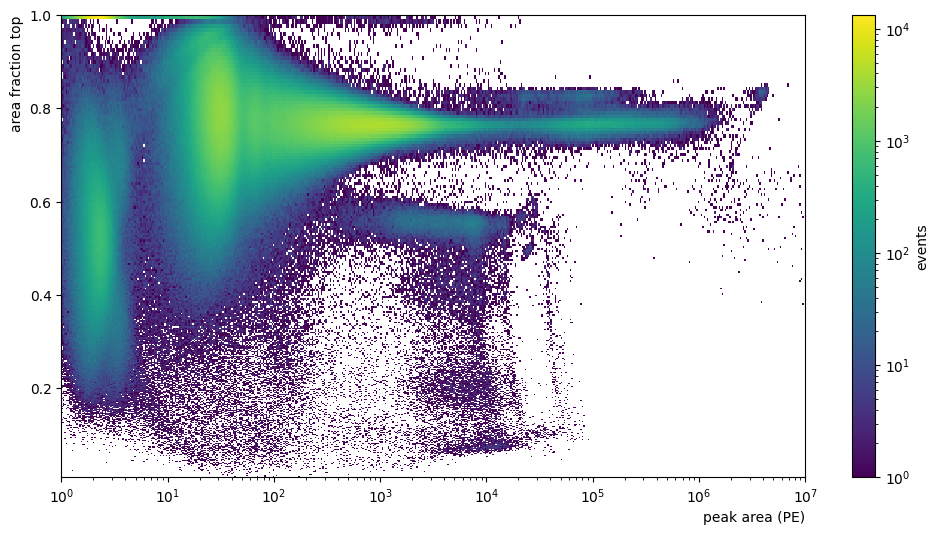

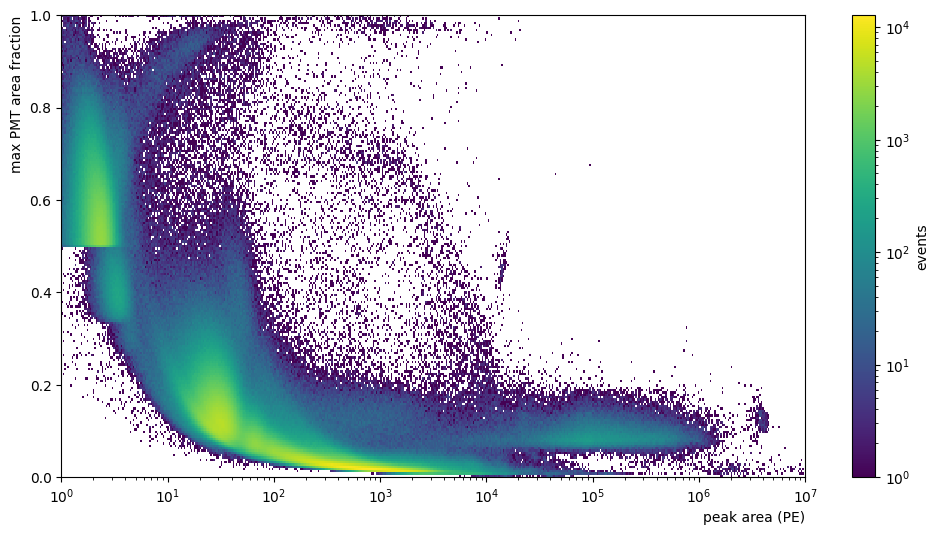

In [63]:
plot_peaks_area_width_aft(peaks,low=0,high=7)

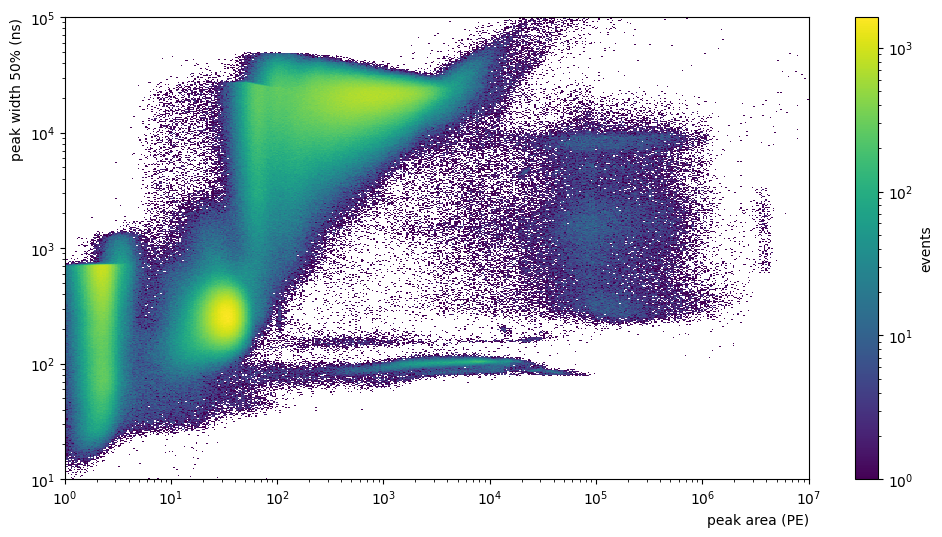

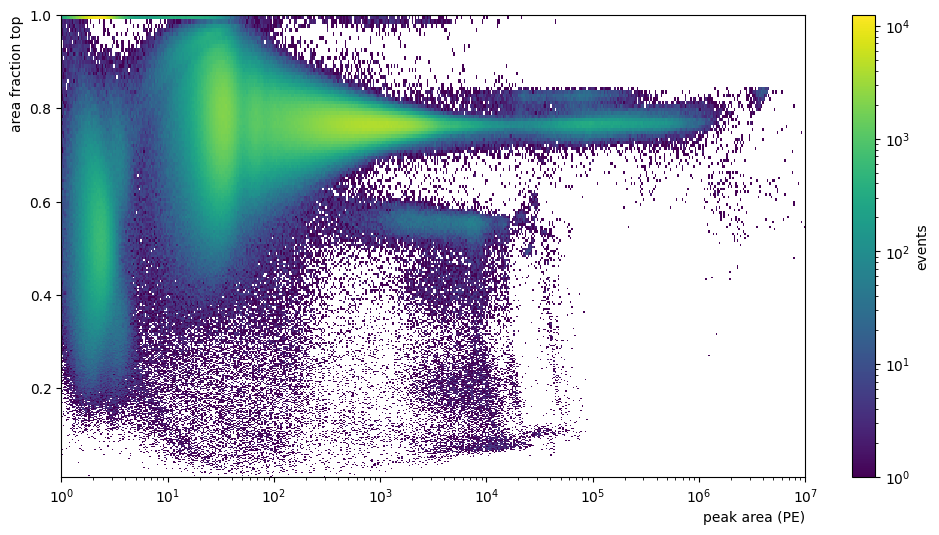

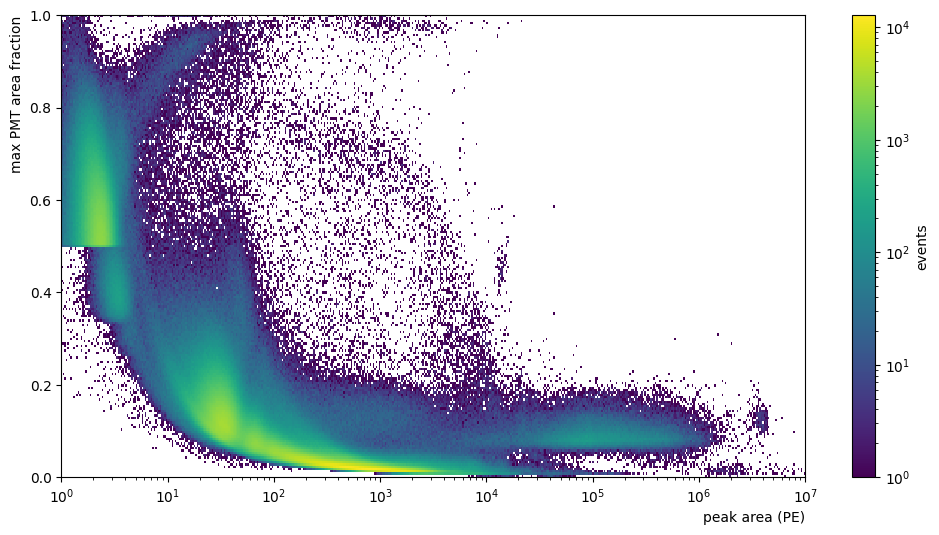

In [64]:
plot_peaks_area_width_aft(peaks0,low=0,high=7)

6779142


Text(0, 1, 'n channels')

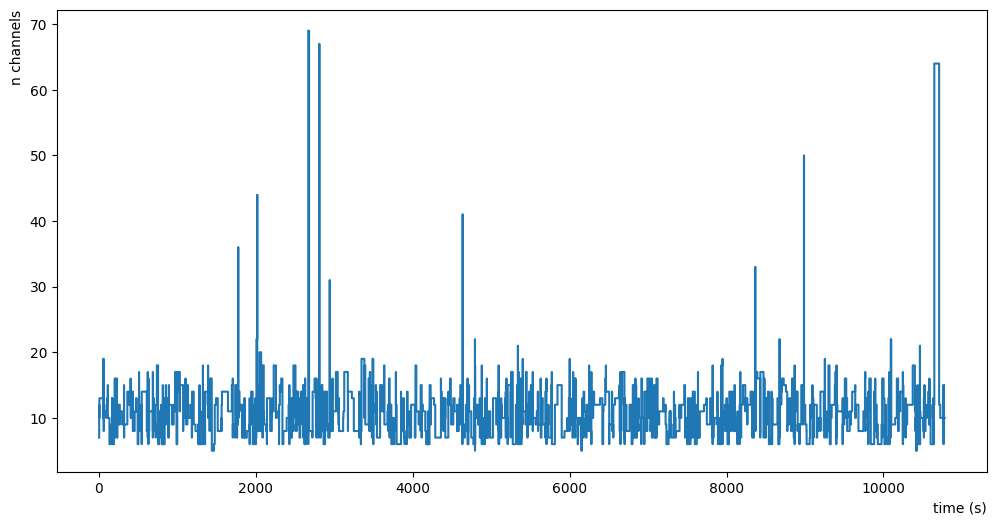

In [73]:
start = peaks['time'][0]
times = (peaks['time']-start)/1e9
chns = peaks['n_channels']
cut = ( peaks['range_50p_area'] > 4e3 ) & ( peaks['area'] < 20 )
print(len(times))
n = -1
plt.figure(figsize=(12,6))
plt.plot(times[:n][cut],chns[:n][cut],ds='steps')
plt.xlabel("time (s)", ha='right', x=1)
plt.ylabel("n channels", ha='right', y=1)
#plt.xscale('log')